# Прогнозные модели для отбора коров в поголовье

Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «XXX». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «XXX2».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «XXX2» готова предоставить подробные данные о своих коровах.

**Цель моделей:**

    1. Первая модель будет прогнозировать возможный удой коровы.
    2. Вторая модель — рассчитывать вероятность получить вкусное молоко от коровы.
    
**Ход исследования:**

    Данные располагаются в трех файлах '/datasets/ferma_main.csv', '/datasets/ferma_dad.csv', '/datasets/cow_buy.csv'. Достану их и изучу общую информацию.
    
    Выполню предобработку данных, проверю данные на дубли. Далее, объединю первые две таблицы в одну. После приступлю к исследованию.
    
    Выделю целеовй признак, проведу корреляционный анализ и затем приступлю к обучению моделей, с последующим их тестированием и интерпретацией.
    
    Таким образом, мое создание моделей машинного обучения пройдет в семь этапов:
        - Загрузка данных
        - Предобработка данных
        - Исследовательский анализ данных
        - Подготовка данных к МО(включая корреляционный анализ)
        - Обучение и тестирование модели линейной регрессии
        - Обучение и тестирование модели логистической регрессии
        - Интерпретирование моделей и вывод

In [1]:
!pip install phik -q

In [2]:
!pip install scikit-learn==1.1.3 -q

## Загрузка данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    mean_absolute_error,
    confusion_matrix,
    accuracy_score, 
    precision_score, 
    recall_score
)

In [4]:
ferma_main = pd.read_csv("/datasets/ferma_main.csv", sep = ";", decimal = ',')

In [5]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [6]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

In [7]:
ferma_dad = pd.read_csv("/datasets/ferma_dad.csv", ";")
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [8]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [9]:
cow_buy = pd.read_csv("/datasets/cow_buy.csv", ";")

In [10]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


In [11]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


**Вывод:**

    - Были выгружены данные из трех разных файлов в три переменные.
    - В таблице ferma_main 634 записи с колонками Идентификатора коровы, Удой(целевая), ЭКЕ (Энергетическая кормовая единица), Сырой протеин, СПО (Сахаро-протеиновое соотношение), Порода, Тип пастбища', порода папы_быка, Жирность, Белок, Вкус молока, Возраст.
    - В таблице ferma_dad 629 записи с колонками идентификатора коровы, имя папы.
    - В таблице cow_buy 20 записей с колонками Порода, Тип пастбища, порода папы_быка, Имя_папы, Текущая_жирность, Текущий_уровень_белок, Возраст.

##  Предобработка данных

In [12]:
ferma_main.columns

Index(['id', 'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
       'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Порода',
       'Тип пастбища', 'порода папы_быка', 'Жирность,%', 'Белок,%',
       'Вкус молока', 'Возраст'],
      dtype='object')

In [13]:
ferma_main.columns = [
    'id', 'milk_yield', 'eke', 'crude_protein', 'spo', 'breed', 
    'type_pasture', 'breed_dad', 'fat_content', 'protein', 'taste', 'age'
]

In [14]:
ferma_main.columns

Index(['id', 'milk_yield', 'eke', 'crude_protein', 'spo', 'breed',
       'type_pasture', 'breed_dad', 'fat_content', 'protein', 'taste', 'age'],
      dtype='object')

In [15]:
ferma_main.isna().sum()

id               0
milk_yield       0
eke              0
crude_protein    0
spo              0
breed            0
type_pasture     0
breed_dad        0
fat_content      0
protein          0
taste            0
age              0
dtype: int64

In [16]:
ferma_main.duplicated().sum()

5

In [17]:
ferma_main = ferma_main.drop_duplicates()

In [18]:
ferma_main.nunique()

id               629
milk_yield       528
eke               55
crude_protein    401
spo               12
breed              2
type_pasture       3
breed_dad          3
fat_content       50
protein           15
taste              2
age                2
dtype: int64

In [19]:

for field in ['spo', 'breed', 'type_pasture', 'breed_dad', 'protein', 'taste', 'age']:
    print(field+":", ferma_main[field].sort_values().unique(), "\n")

spo: [0.84  0.85  0.86  0.88  0.885 0.89  0.895 0.9   0.93  0.94  0.95  0.96 ] 

breed: ['Вис Бик Айдиал' 'РефлешнСоверинг'] 

type_pasture: ['Равнинное' 'Равнинные' 'Холмистое'] 

breed_dad: ['Айдиал' 'Айдиалл' 'Соверин'] 

protein: [3.069 3.07  3.071 3.072 3.073 3.074 3.075 3.076 3.077 3.078 3.079 3.08
 3.081 3.082 3.085] 

taste: ['вкусно' 'не вкусно'] 

age: ['более_2_лет' 'менее_2_лет'] 



In [20]:
ferma_main['type_pasture'] = ferma_main['type_pasture'].replace(['Равнинные'], 'Равнинное')

In [21]:
ferma_main['breed_dad'] = ferma_main['breed_dad'].replace(['Айдиалл'], 'Айдиал')

In [22]:
ferma_main['eke'].unique()

array([14.2, 12.8, 14. , 12.4, 12.7, 13.2, 14.7, 13.4, 13.7, 16.5, 15.4,
       14.5, 16. , 15.6, 11.5, 15.7, 14.3, 15.5, 14.6, 15.9, 15.2, 14.8,
       16.4, 11.8, 14.4, 16.1, 12.9, 13.8, 13.3, 16.3, 13.9, 14.1, 16.7,
       15.8, 16.2, 12.2, 14.9, 13.6, 12.5, 16.8, 13.5, 15.1, 12.1, 16.6,
       15.3, 13.1, 12.3, 11.9, 12.6, 15. , 13. , 12. , 11.1, 11.7, 10.9])

In [23]:
#for field in ['eke', 'spo', 'fat_content', 'protein']:
#    try:
#        ferma_main[field] = ferma_main[field].str.strip().str.replace(',', '.').astype('float')
#    except:
#        print('cant convert field ', field ,'to numeric')

In [24]:
ferma_dad.columns = ['id', 'dad_name']

In [25]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [26]:
ferma_dad.isna().sum()

id          0
dad_name    0
dtype: int64

In [27]:
ferma_dad.duplicated().sum()

0

In [28]:
ferma_dad['dad_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [29]:
ferma_data = ferma_main.merge(ferma_dad, on='id')

In [30]:
ferma_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             629 non-null    int64  
 1   milk_yield     629 non-null    int64  
 2   eke            629 non-null    float64
 3   crude_protein  629 non-null    int64  
 4   spo            629 non-null    float64
 5   breed          629 non-null    object 
 6   type_pasture   629 non-null    object 
 7   breed_dad      629 non-null    object 
 8   fat_content    629 non-null    float64
 9   protein        629 non-null    float64
 10  taste          629 non-null    object 
 11  age            629 non-null    object 
 12  dad_name       629 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 68.8+ KB


In [31]:
cow_buy.isna().sum()

Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

In [32]:
cow_buy.duplicated().sum()

4

In [33]:
#cow_buy = cow_buy.drop_duplicates()

In [34]:
cow_buy.nunique()

Порода                      2
Тип пастбища                2
порода папы_быка            2
Имя_папы                    4
Текущая_жирность,%         12
Текущий_уровень_белок,%    12
Возраст                     2
dtype: int64

In [35]:
cow_buy.columns = ['breed', 'type_pasture', 'breed_dad', 'dad_name', 'current_fat_content', 'current_protein', 'age']

In [36]:
for field in ['breed', 'type_pasture', 'breed_dad', 'dad_name', 'current_fat_content', 'current_protein', 'age']:
    print(field+":", cow_buy[field].sort_values().unique(), "\n")

breed: ['Вис Бик Айдиал' 'РефлешнСоверинг'] 

type_pasture: ['равнинное' 'холмистое'] 

breed_dad: ['Айдиал' 'Соверин'] 

dad_name: ['Барин' 'Буйный' 'Геркулес' 'Соловчик'] 

current_fat_content: ['3,34' '3,4' '3,42' '3,54' '3,57' '3,58' '3,59' '3,63' '3,64' '3,68'
 '3,73' '3,77'] 

current_protein: ['3,046' '3,053' '3,055' '3,061' '3,065' '3,069' '3,073' '3,074' '3,075'
 '3,076' '3,079' '3,081'] 

age: ['более_2_лет' 'менее_2_лет'] 



In [37]:
for field in ['current_fat_content', 'current_protein']:
    try:
        cow_buy[field] = cow_buy[field].str.strip().str.replace(',', '.').astype('float')
    except:
        print('cant convert field ', field ,'to numeric')

In [38]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   breed                20 non-null     object 
 1   type_pasture         20 non-null     object 
 2   breed_dad            20 non-null     object 
 3   dad_name             20 non-null     object 
 4   current_fat_content  20 non-null     float64
 5   current_protein      20 non-null     float64
 6   age                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [39]:
ferma_data['type_pasture'] = ferma_data['type_pasture'].str.lower()

In [40]:
ferma_data['type_pasture'].unique()

array(['равнинное', 'холмистое'], dtype=object)

In [41]:
ferma_data.isna().sum()

id               0
milk_yield       0
eke              0
crude_protein    0
spo              0
breed            0
type_pasture     0
breed_dad        0
fat_content      0
protein          0
taste            0
age              0
dad_name         0
dtype: int64

In [42]:
cow_buy.isna().sum()

breed                  0
type_pasture           0
breed_dad              0
dad_name               0
current_fat_content    0
current_protein        0
age                    0
dtype: int64

**Вывод:**

    - Поля были переименованы и нормализованы к snake case.
    - Был приведен тип float, в полях, где он был строкой.
    - Дубликаты были устранены, как явные, так и неявные в таблицах ferma_main и cow_buy(в таблице ferma_dad дубликатов не найдено).
    - Пропущенных значений найдено не было.

## Исследовательский анализ данных

In [43]:
ferma_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             629 non-null    int64  
 1   milk_yield     629 non-null    int64  
 2   eke            629 non-null    float64
 3   crude_protein  629 non-null    int64  
 4   spo            629 non-null    float64
 5   breed          629 non-null    object 
 6   type_pasture   629 non-null    object 
 7   breed_dad      629 non-null    object 
 8   fat_content    629 non-null    float64
 9   protein        629 non-null    float64
 10  taste          629 non-null    object 
 11  age            629 non-null    object 
 12  dad_name       629 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 68.8+ KB


In [44]:
def pivot_pie(title, table, index, values, funcs):
    pivot = table.pivot_table(index=index, values=values, aggfunc=funcs)
    
    if funcs[0] == 'count':
        total = pivot[funcs[0]].sum()
        pivot['Количество'] = pivot[funcs[0]] / total
        pivot['Количество'].plot(kind='pie', autopct='%.1f%%', figsize=(10, 7), startangle=90)
    else:
        pivot.columns = funcs
        for f in funcs:
            pivot[f].plot(kind='pie', autopct='%.1f%%', figsize=(10, 7), startangle=90)
            plt.title(title)
            plt.legend()
            plt.show()

In [45]:
def pivot_bar(title, ylabel, xlabel, table, index, values, funcs):
    pivot = table.pivot_table(index=index, values=values, aggfunc=funcs).sort_values(by=index)
    
    if funcs[0] == 'count':
        pivot.plot(kind='bar', y='count', figsize=(15, 7), grid=True)
    else:
        pivot.columns = funcs
        for f in funcs:
            pivot.plot(kind='bar', y=f, figsize=(15, 7), grid=True)
    plt.title(title)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

**Посмотрим какие доли составляет возраст коров до и после 2 лет**

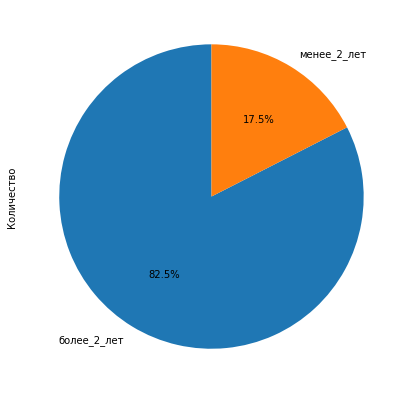

In [46]:
pivot_pie('Возраст коров', ferma_data, 'age', 'id', ['count'])

_Коровы с возрастом более 2 лет составляют большую долю от всех коров фермы_

**Посмотрим какие доли составляют породы коров**

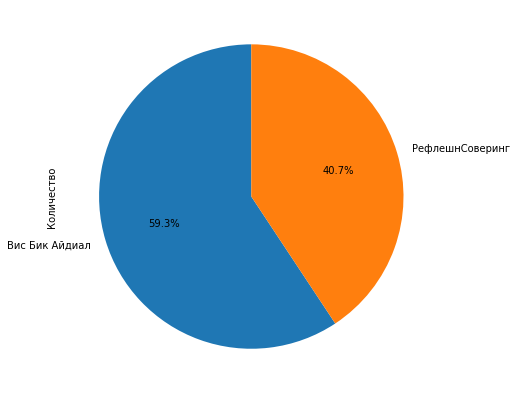

In [47]:
pivot_pie('Количество коров', ferma_data, 'breed', 'id', ['count'])

_Видим, что количество породы Вис Бик Айдиал слегка преобладает(почти на 10 процентов)_

**Проверим доли коров по именам**

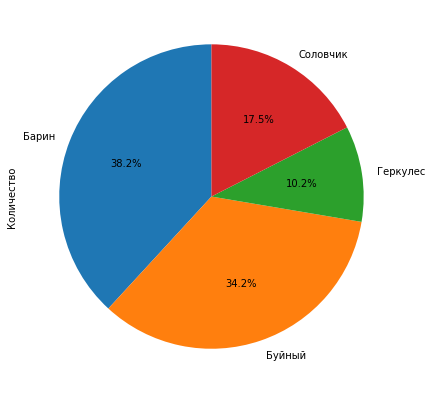

In [48]:
pivot_pie('Количество коров', ferma_data, 'dad_name', 'id', ['count'])

_Имена Барин и Буйный преобладают. Имена важны как социально-культурный фактор для удоя молока. Например, исследования показывают, что коровы с именами дают больше молока._

**Проверим зависимость удоя от ЭКЕ**

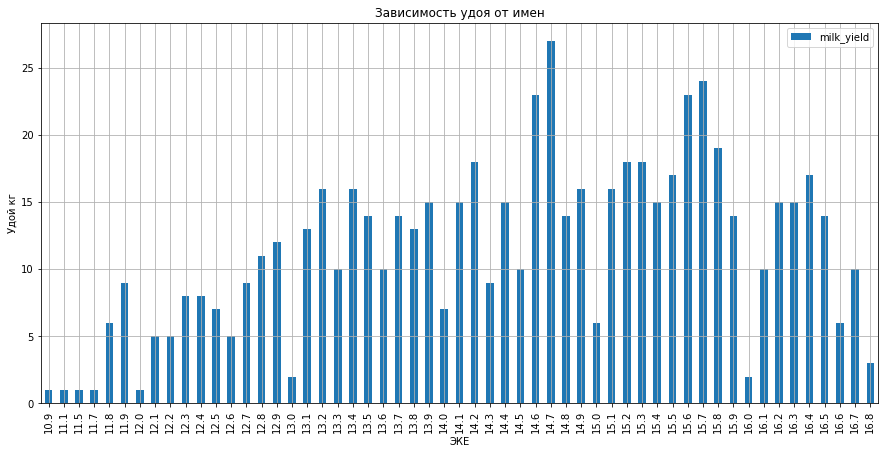

In [49]:
pivot_bar('Зависимость удоя от имен', 'Удой кг', 'ЭКЕ', ferma_data, 'eke', 'milk_yield', ['count'])

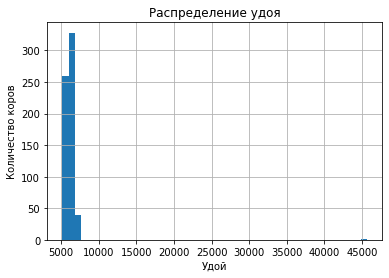

In [50]:
plt.hist(ferma_data['milk_yield'], bins=50)
plt.grid(True)
plt.title('Распределение удоя')
plt.xlabel('Удой')
plt.ylabel('Количество коров')
plt.show()

In [51]:
ferma_data = ferma_data.drop(ferma_data.loc[ferma_data['milk_yield'] == 45616].index)

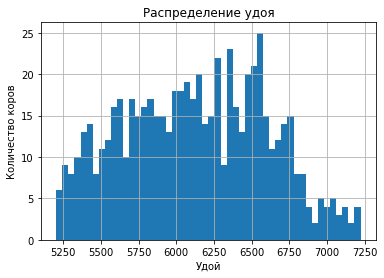

In [52]:
plt.hist(ferma_data['milk_yield'], bins=50)
plt.grid(True)
plt.title('Распределение удоя')
plt.xlabel('Удой')
plt.ylabel('Количество коров')
plt.show()

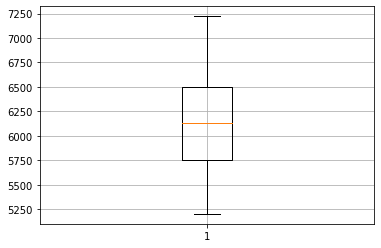

In [53]:
plt.boxplot(ferma_data['milk_yield'])
plt.grid(True)

In [54]:
ferma_data.describe()

,id,milk_yield,eke,crude_protein,spo,fat_content,protein
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,315.474522,6125.968153,14.548726,1923.759554,0.913089,3.604268,3.075670
std,181.475367,475.857053,1.301777,182.832816,0.032221,0.168093,0.002551
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.750000,5749.750000,13.500000,1771.750000,0.890000,3.590000,3.074000
50%,315.500000,6132.500000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.250000,6501.000000,15.600000,2062.250000,0.940000,3.720000,3.077000
max,629.000000,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


_Удой относительно ЭКЕ не выявил каких либо выбросов. Тем не менее распределение удоя относительно количество коров выявило выброс на значении 45616 и был устранен. Оба признака не соответствуют нормальному распределению._

**Теперь посмотрим как влияет качество пищи и молока на удой**

Жирность :


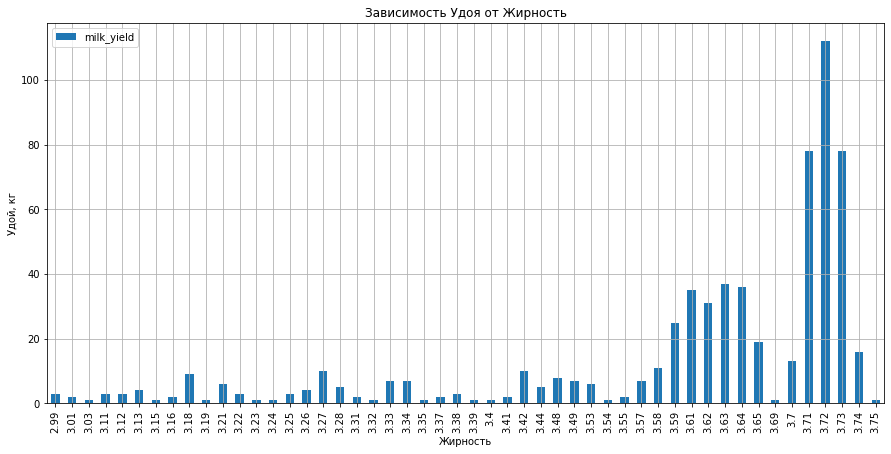

Белок :


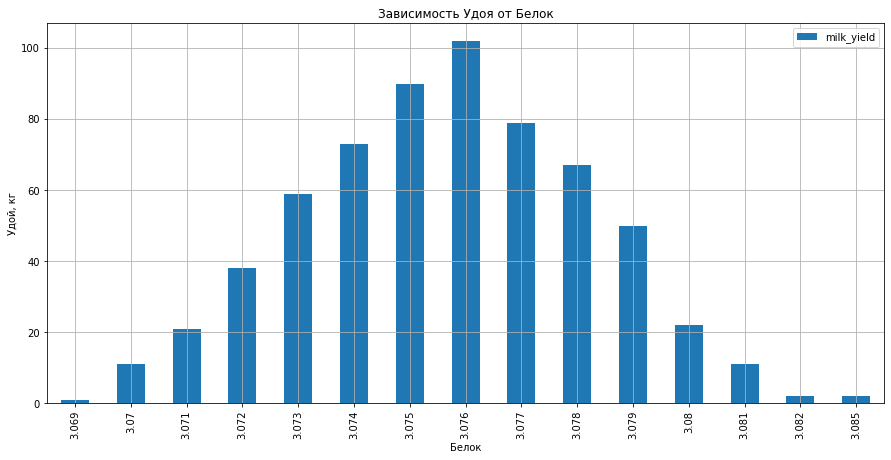

СПО :


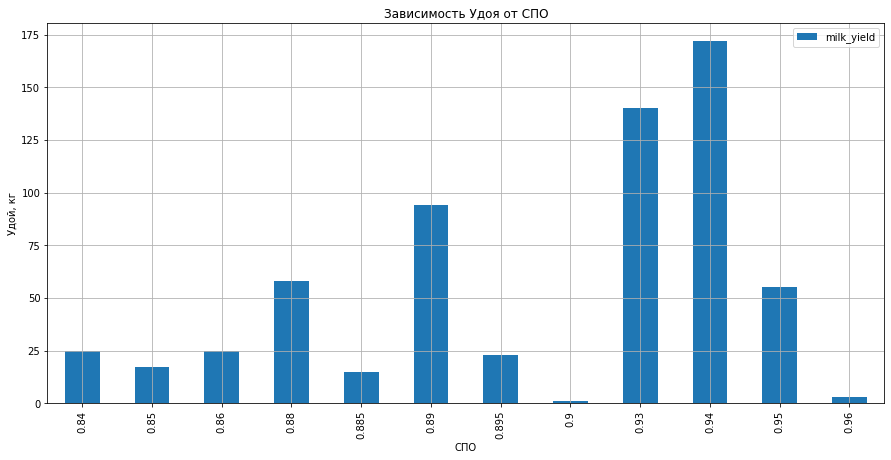

In [55]:
for row in [
    ['Жирность', 'fat_content'],
    ['Белок', 'protein'],
    ['СПО', 'spo']
]:
    print(row[0], ":")
    pivot_bar('Зависимость Удоя от '+ row[0], 'Удой, кг', row[0], ferma_data, row[1], 'milk_yield', ['count'])

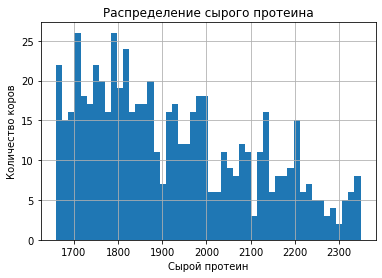

In [56]:
plt.hist(ferma_data['crude_protein'].sort_values(), bins=50)
plt.grid(True)
plt.title('Распределение сырого протеина')
plt.xlabel('Сырой протеин')
plt.ylabel('Количество коров')
plt.show()

_Из данных по отношению пищи к Удою видно, что Белок имеет нормальное распределение, в отличие от остальных показателей. Жирность в районе 3.73 показало наиболее благоприятные статистические показатели для Удоя. А также СПО в районе 0.93-0.94 хорошо сказывается на удое. Сырой протеин в районе 1700-1850 г давали наибольшему числу коров._

_Жирность, СПО и Сырой протеин не имеют нормального распределения._

**Теперь посмотрим показатели, влияющие на Вкус молока**

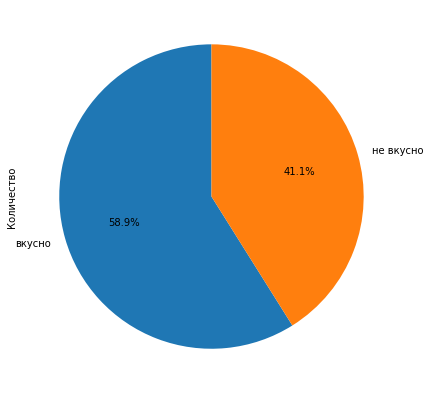

In [57]:
pivot_pie('Возраст коров', ferma_data, 'taste', 'breed', ['count'])

_Доля вкусного молока составляет 59% от всего._

**Рассмотрим соотношение породы со вкусом молока в количественной характеристике**

вкусно:
не вкусно:


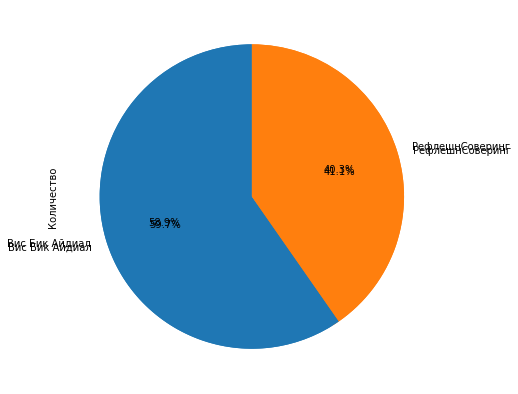

In [58]:
for tst in ['вкусно', 'не вкусно']:
    print(tst+":")
    pivot_pie('Зависимость вкуса молока от породы', ferma_data.loc[ferma_data['taste'] == tst], 'breed', 'taste', ['count'])

_Соотношение породы к вкусу молока показывает, что порода не повлияла на вкус молока в текущей выборке. Так как имеем процент породы вкусного и не вкусного молока равным к общему соотношению пород._

**Теперь проверим зависимость вкуса от качественных характеристик пищи**

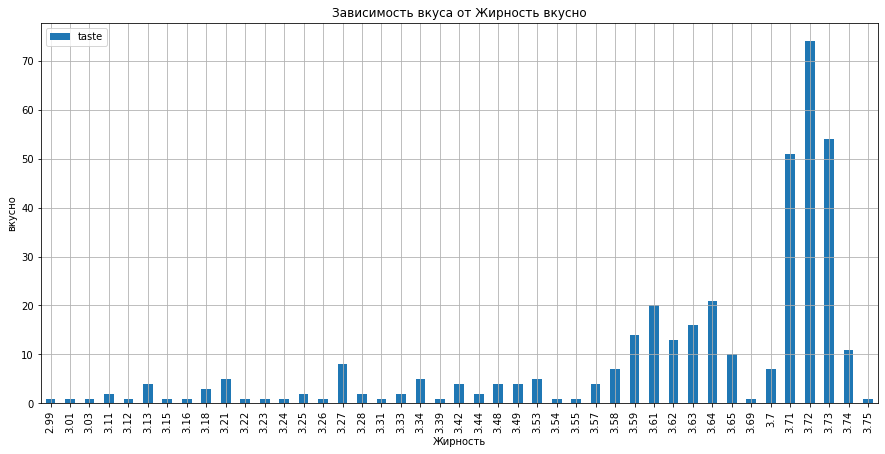

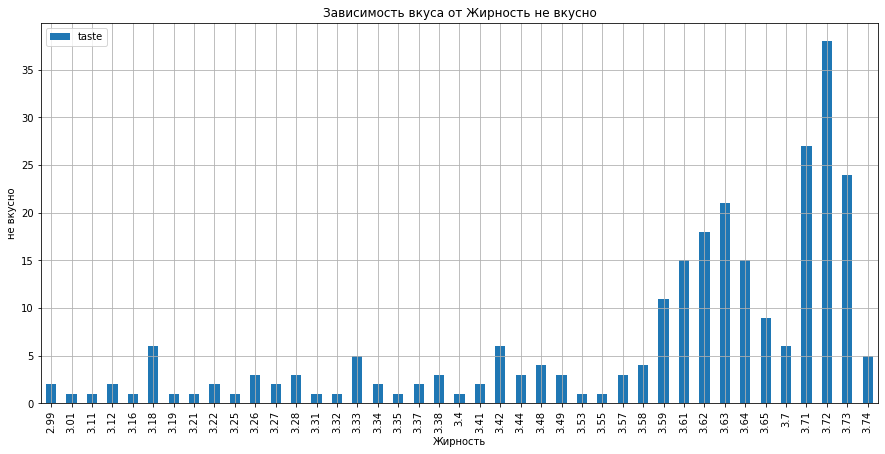

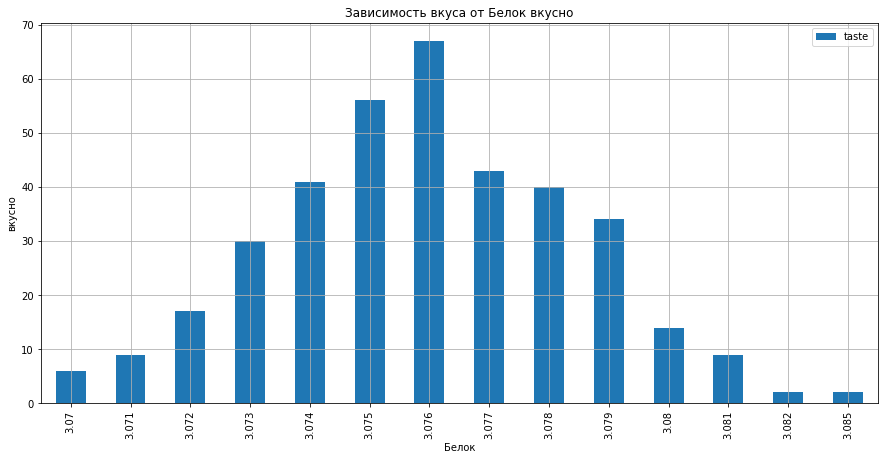

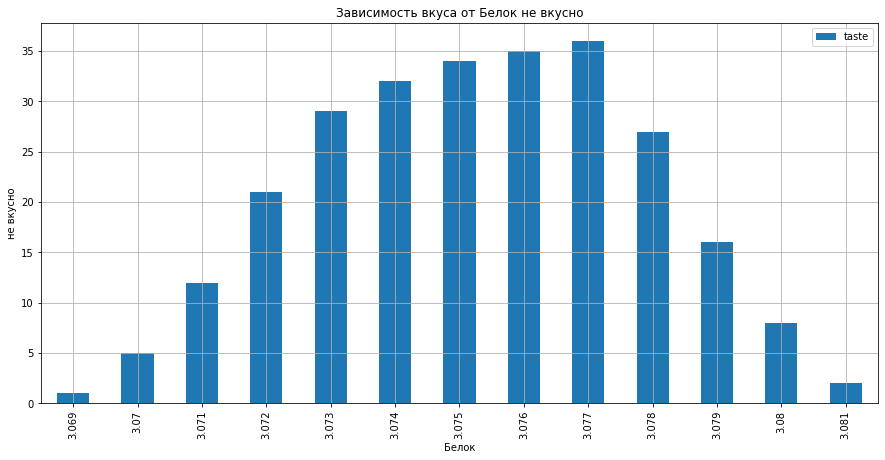

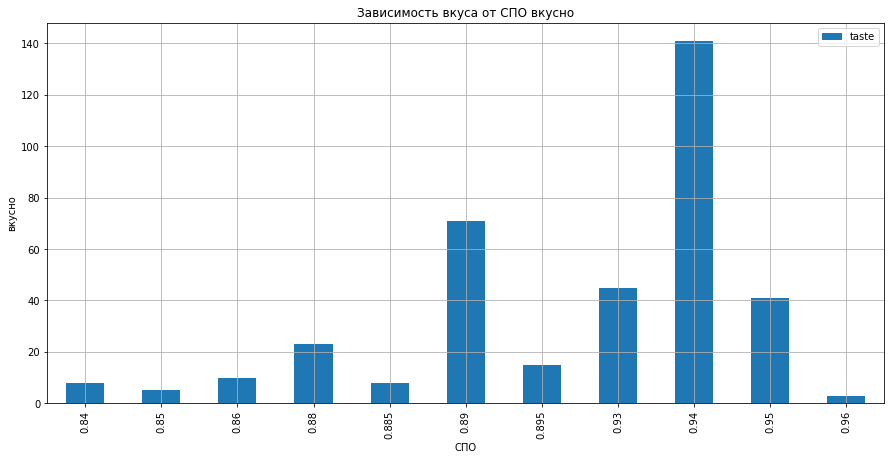

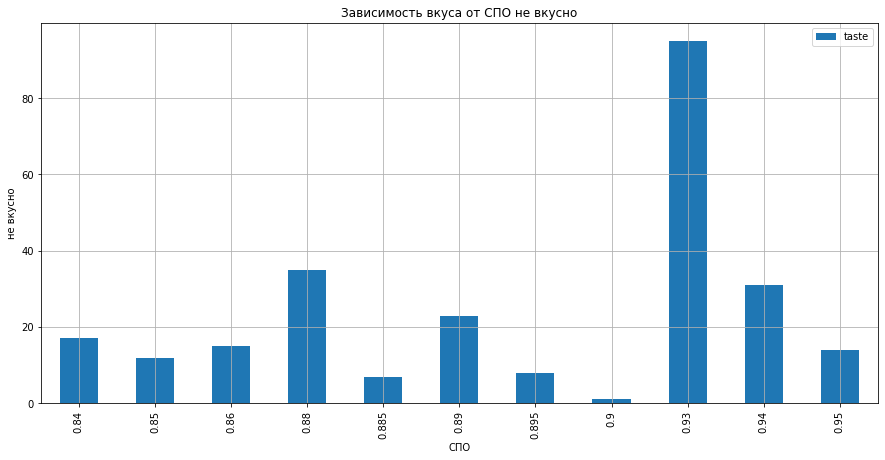

In [59]:
for row in [
    ['Жирность', 'fat_content'],
    ['Белок', 'protein'],
    ['СПО', 'spo']
]:
    for tst in ['вкусно', 'не вкусно']:
        pivot_bar('Зависимость вкуса от '+ row[0]+ " "+ tst, tst, row[0], ferma_data.loc[ferma_data['taste'] == tst], row[1], 'taste', ['count'])

_Показатели по пище говорят о том, что жирность пищи примерно одинакова до показателя от 3.71 до 3.73 - в этом показателе количество вкусного молока больше всего._
_Белок практически не влияетна не вкусное молоко, тем не менее больше всего вкусного на показателе 3.076._
_СПО указывает на равные показатели на 0.93, тем не менее при показателе 0.9 появляется только для не вкусного молока, хоть и незначительна, но ее проще избежать. Так же сравнивая 0.89 и 0.95 мы имеем большую долю вкусного молока, чем не вкусного._

**Вывод:**

    - Коровы с возрастом более 2 лет составляют большую долю от всех коров фермы
    - Видим, что количество породы Вис Бик Айдиал слегка преобладает(почти на 10 процентов)
    - Имена Барин и Буйный преобладают. Имена важны как социально-культурный фактор для удоя молока. Например, исследования показывают, что коровы с именами дают больше молока
    - Удой относительно ЭКЕ не выявил каких либо выбросов. Тем не менее распределение удоя относительно количество коров выявило выброс на значении 45616 и был устранен. Оба признака не соответствуют нормальному распределению.
    - Из данных по отношению пищи и молока к Удою видно, что Белок молока имеет нормальное распределение, в отличие от остальных показателей. Жирность молока в районе 3.73 показало наиболее благоприятные статистические показатели для Удоя. А также СПО в районе 0.93-0.94 хорошо сказывается на удое. Сырой протеин в районе 1700-1850 г давали наибольшему числу коров.
    - Доля вкусного молока составляет 59% от всего.
    - Соотношение породы к вкусу молока показывает, что порода не повлияла на вкус молока в текущей выборке. Так как имеем процент породы вкусного и не вкусного молока равным к общему соотношению пород.
    - Показатели по пище говорят о том, что жирность пищи примерно одинакова до показателя от 3.71 до 3.73 - в этом показателе количество вкусного молока больше всего. Белок практически не влияетна не вкусное молоко, тем не менее больше всего вкусного на показателе 3.076. СПО указывает на равные показатели на 0.93, тем не менее при показателе 0.9 появляется только для не вкусного молока, хоть и незначительна, но ее проще избежать. Так же сравнивая 0.89 и 0.95 мы имеем большую долю вкусного молока, чем не вкусного.

## Корреляционный анализ

**Посмотрим на тепловую карту корреляции признаков**

<AxesSubplot:>

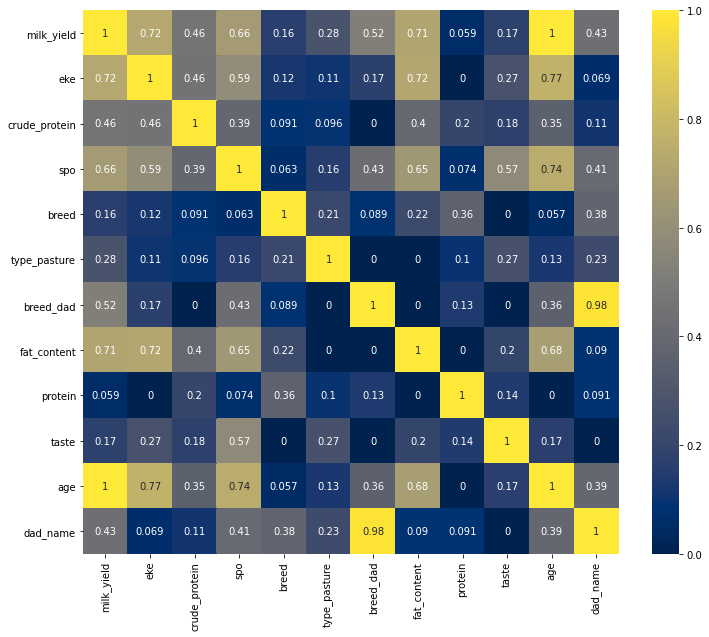

In [60]:
fig, ax = plt.subplots(figsize=(12, 10))
#sns.heatmap(ferma_data.corr(method='spearman'), annot=True, cmap='cividis', ax=ax)
ferma_data = ferma_data.drop('id', axis=1)
phik_matrix = ferma_data.phik_matrix(interval_cols=['milk_yield', 'eke', 'spo', 'crude_protein', 'fat_content', 'protein'])
sns.heatmap(phik_matrix, annot=True, cmap='cividis', ax=ax)

In [61]:
ferma_data = ferma_data.drop('breed_dad', axis=1)

_Был обнаружен риск мультиколлинеарности - dad_name и breed_dad имели коэффициент корреляциии больше 0.9. Путем удаления поля dad_name был устранен весьма высокий показатель корреляции._

In [62]:
ferma_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   milk_yield     628 non-null    int64  
 1   eke            628 non-null    float64
 2   crude_protein  628 non-null    int64  
 3   spo            628 non-null    float64
 4   breed          628 non-null    object 
 5   type_pasture   628 non-null    object 
 6   fat_content    628 non-null    float64
 7   protein        628 non-null    float64
 8   taste          628 non-null    object 
 9   age            628 non-null    object 
 10  dad_name       628 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 58.9+ KB


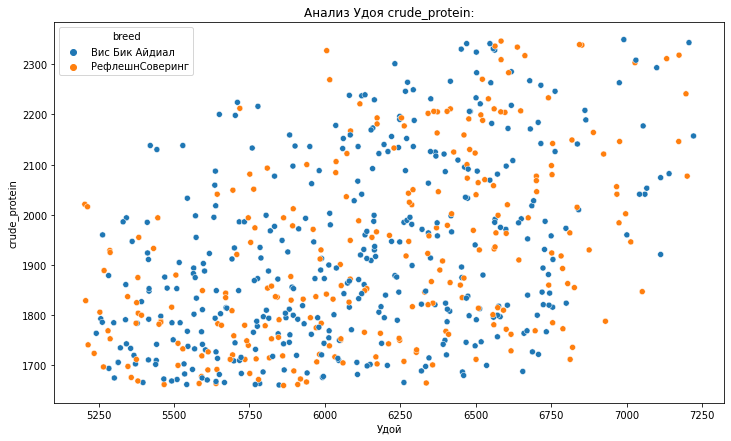

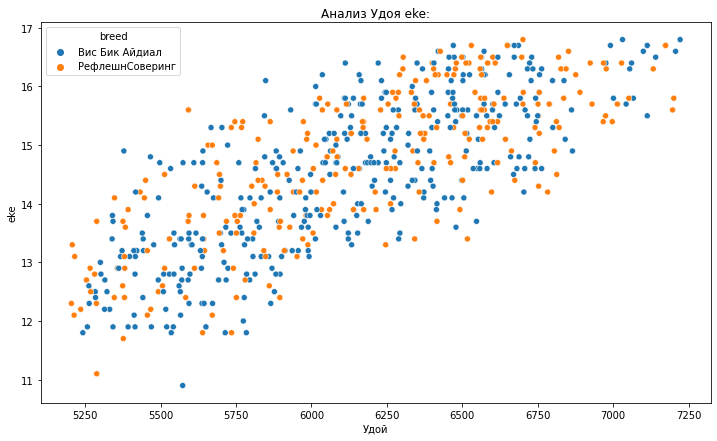

In [63]:
ferma_data = ferma_data.drop(ferma_data.loc[ferma_data['milk_yield'] == 45616].index)
for field in ['crude_protein', 'eke']:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=ferma_data, x='milk_yield', y=field, hue='breed')
    plt.title("Анализ Удоя "+field+":")
    plt.xlabel("Удой")
    plt.ylabel(field)
    plt.show()

In [64]:
ferma_data['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

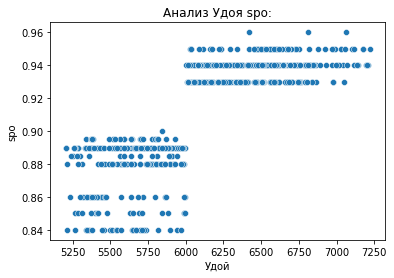

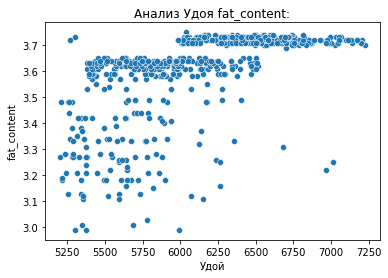

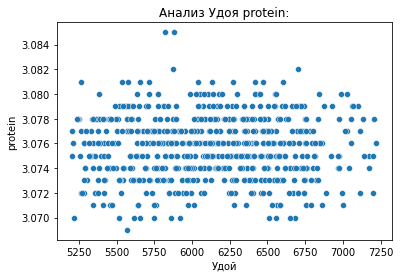

In [65]:
for field in ['spo', 'fat_content', 'protein']:
    sns.scatterplot(data=ferma_data, x='milk_yield', y=field)
    plt.title("Анализ Удоя "+field+":")
    plt.xlabel("Удой")
    plt.ylabel(field)
    plt.show()

**Вывод:**

    - Был обнаружен риск мультиколлинеарности - dad_name и breed_dad имели коэффициент корреляциии больше 0.9. Путем удаления поля dad_name был устранен весьма высокий показатель корреляции.
    - Можем наблюдать, что признак spo(СПО) и fat_content(Жирность) и eke(ЭКЕ) коррелируют между собой.
    - Наблюдается высокая корреляция у признаков СПО, Жирность и Белок.
    - Низкая корреляция у показателей Эке и Сырой протеин.
    - Нелинейная связь у Сырым протеином, ЭКЕ и удоем(сильная корреляция), жирность
    - Линейная связь у сырого протеина с удоем.
    - Чтобы убрать нелинейность - следует, масштабировать признаки. Новые признаки вводить не придется.

## Обучение модели линейной регрессии

In [67]:
ferma_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   milk_yield     628 non-null    int64  
 1   eke            628 non-null    float64
 2   crude_protein  628 non-null    int64  
 3   spo            628 non-null    float64
 4   breed          628 non-null    object 
 5   type_pasture   628 non-null    object 
 6   fat_content    628 non-null    float64
 7   protein        628 non-null    float64
 8   taste          628 non-null    object 
 9   age            628 non-null    object 
 10  dad_name       628 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 75.0+ KB


In [69]:
new_columns_order = [
    'milk_yield','crude_protein', 'eke',
    'spo', 'fat_content', 'protein', 'breed', 
    'type_pasture', 'taste', 'age', 'dad_name'
]
ferma_data = ferma_data[new_columns_order]

RANDOM_STATE = 47

In [70]:
def linear_model(data, scale_fields, encode_fields):
    # Выделим входные и целевые признаки
    X = data.drop(['milk_yield', 'taste'], axis=1)
    fields = scale_fields+encode_fields
    X = data.loc[:, fields]
    y = data['milk_yield']
    
    # Разделим выборки на тренировочную и тестовую(в нашем случае, скорее, валидационная)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE
    )
    
    # Масштабируем количественные признаки
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[scale_fields])
    X_test_scaled = scaler.transform(X_test[scale_fields])
    
    # Кодируем категориальные признаки
    encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
    X_train_ohe = encoder.fit_transform(X_train[encode_fields])
    X_test_ohe = encoder.transform(X_test[encode_fields])
    
    # Объединяем признаки
    X_train_ready = np.concatenate((X_train_scaled, X_train_ohe), axis=1)
    X_test_ready = np.concatenate((X_test_scaled, X_test_ohe), axis=1)
    
    # Обучение модели
    model_lr = LinearRegression()
    model_lr.fit(X_train_ready, y_train)
    predictions = model_lr.predict(X_test_ready)
    
    # Рассчет качества модели и анализ остатков
    r2 = r2_score(y_test, predictions)
    print("R2_score: ", round(r2,2))
    
    residuals = y_test - predictions

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].grid(True)
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    
    plt.grid(True)
    plt.show()
    
    return model_lr, y_test, predictions, residuals, scaler, encoder

_Для количественных признаков были выбраны - Сырой протеин, СПО, ЕКЭ так как они непосредственно влияют на Удой. Были исключены признаки Жирности и Белка в молоке, потому что они уже не влияют на сам Удой, это характеристики постфактум, который произошли после всех предыдущих процессов._

_Корреляции в признаках 'breed', 'type_pasture', 'breed_dad', 'age' замечено не было, а так же все они будут влиять на Удой, кроме имени отца быка(этот признак был исключен)_

R2_score:  0.77


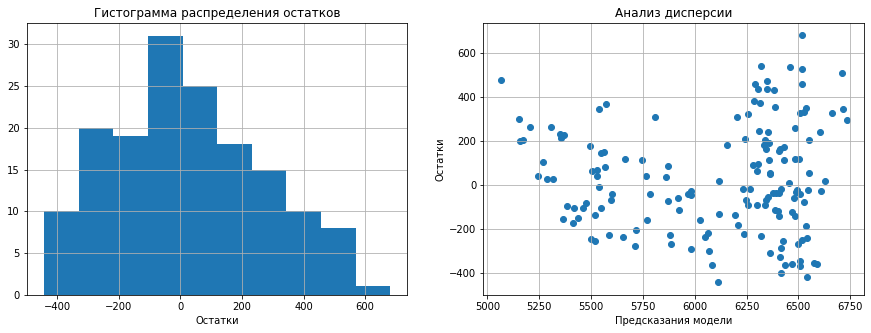

In [71]:
model_1, y_test_1, predictions_1, residuals_1, scaler_1, encoder_1 = linear_model(
    ferma_data, 
    ['crude_protein', 'spo', 'eke'], 
    ['breed', 'type_pasture', 'age']
)

_R2 метрика имеет хороший показатель в 0.77._
_График несиметричен относительно нуля, он смещен влево. Это значит, что среднее значение остатков модели не равно 0. Модель некачественная._

_Дисперсия показывает, что на графике образуется "Дуга". То есть распределение напоминает дугу, несмотря на незначительные значения вне дуги. Следовательно - модель учла не все закономерности в данных._

_Модели требуются дополнительные исследования. Добавить дополнительный признак(имя папы быка), так же можно попробовать исключить нелинейность признаков ЭКЕ и СПО, чтобы добавить их к данным._

In [72]:
ferma_data['spo_cat'] = ferma_data['spo'].apply(lambda x: 1 if x > 0.89 else 0)

In [73]:
ferma_data['eke_sqrt'] = ferma_data['eke'] * ferma_data['eke']

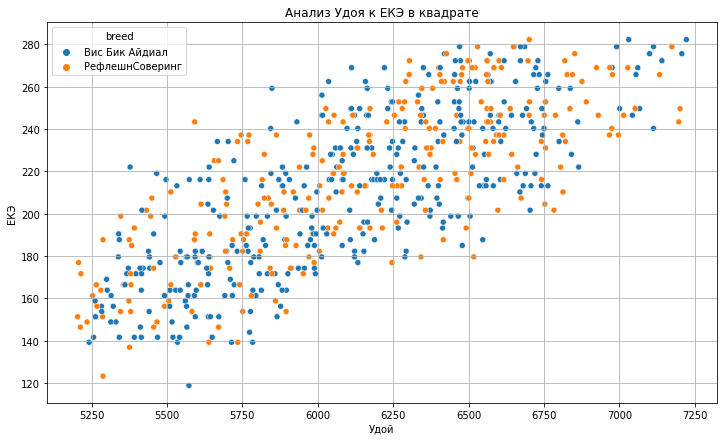

In [74]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=ferma_data, x='milk_yield', y='eke_sqrt', hue='breed')
plt.grid(True)
plt.title("Анализ Удоя к ЕКЭ в квадрате")
plt.xlabel("Удой")
plt.ylabel("ЕКЭ")
plt.show()

R2_score:  0.78


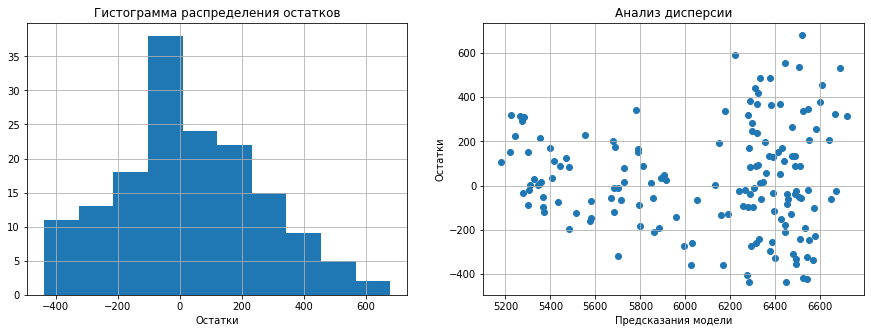

In [75]:
model_2, y_test_2, predictions_2, residuals_2, scaler_2, encoder_2 = linear_model(
    ferma_data, 
    ['crude_protein', 'eke_sqrt'], 
    ['breed', 'type_pasture', 'age', 'spo_cat']
)

_R2 метрика изменилась - 0.78_

_График стал более симетричен, но имеет выброс слева от нуля._

_Дисперсия также улучшилась и уже меньше напоминает дугу, тем не менее ее все еще можно увидеть._

_Модель все еще нуждается в дополнительных исследованиях. Осталось попробовать добавить признак имя папы быка и посмотреть на результат_

In [76]:
ferma_data['dad_name'].sort_values().unique()

array(['Барин', 'Буйный', 'Геркулес', 'Соловчик'], dtype=object)

R2_score:  0.83


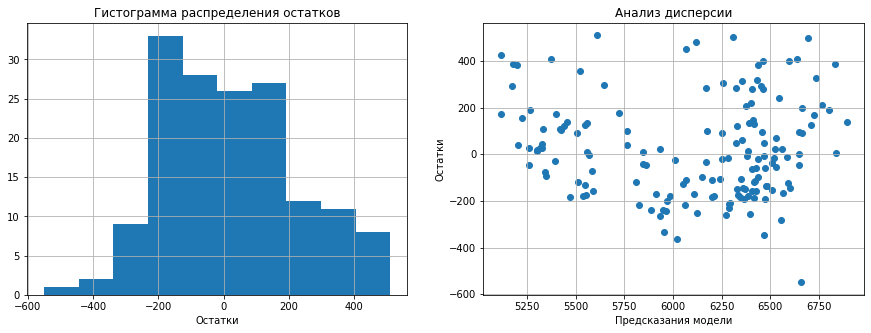

In [77]:
model_3, y_test_3, predictions_3, residuals_3, scaler_3, encoder_3 = linear_model(
    ferma_data, 
    ['crude_protein', 'eke_sqrt'], 
    ['breed', 'type_pasture', 'age', 'spo_cat', 'dad_name']
)

_R2 метрика составляет 0.83 сотых - это лучший показатель из всех трех моделей._

_График больше похож на нормальное распределение, чем предыдущие._

_Дисперсия сильно улучшилась, дуги больше нет._

_Теперь модель более приемлема для предсказаний и в дополнительных исследованиях на имеющихся данных не нуждается. Тем не менее, если есть возможность дополнить данные более разнообразными, добавив больше усредненных значений в данные, то это еще улучшит модель и уберет промежуток в нуле._

**Сравнение моделей:**

_Сравнивая все три модели можно сказать, что последняя наиболее приемлема для работы по всем показателям. Первая модель, хоть и имеет метрику R2 лучше, чем вторая, тем не менее из-за графика смещенного влево она будет плохо предсказывать малый удой. Вторая модель лучше первой по всем метрикам, кроме R2(в тысячных) и больше пригодна для предсказаний чем первая. Третья модель имеет наибольшую метрику R2 и это закреплено анализом дисперсии, график так же имеет хорошее распределение, лучшее из всех трех вариантов._

In [78]:
for m in [
    [y_test_1, predictions_1],
    [y_test_2, predictions_2],
    [y_test_3, predictions_3]
]:
    mse = mean_squared_error(m[0], m[1])
    rmse = mean_squared_error(m[0], m[1], squared=False)
    mae = mean_absolute_error(m[0], m[1])
    
    print("MSE:", mse, "RMSE:", rmse, "MAE:", mae)

MSE: 58837.286959935474 RMSE: 242.56398529034658 MAE: 197.29618195768174
MSE: 56546.51047683071 RMSE: 237.79510187728994 MAE: 187.91813250873528
MSE: 43707.38417989821 RMSE: 209.0631105190445 MAE: 167.59454798369686


In [79]:
lower_quantile = np.quantile(residuals_3, 0.025)
upper_quantile = np.quantile(residuals_3, 0.975)

In [80]:
lower_bound = predictions_3 + lower_quantile
upper_bound = predictions_3 + upper_quantile

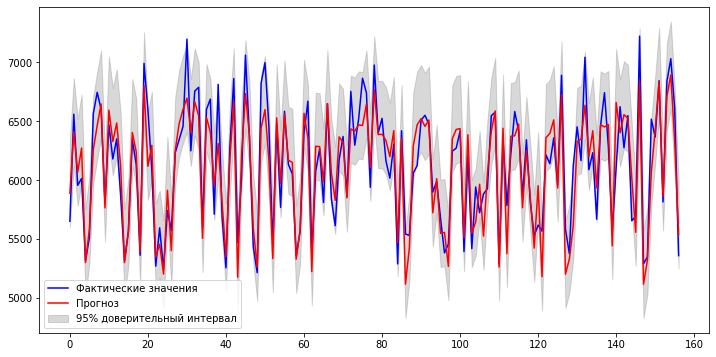

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_3.values, label='Фактические значения', color='blue')
plt.plot(predictions_3, label='Прогноз', color='red')
plt.fill_between(
    range(len(y_test_3)), 
    lower_bound, 
    upper_bound, 
    color='gray', 
    alpha=0.3, 
    label='95% доверительный интервал'
)
plt.legend()
plt.show()

In [82]:
inside_interval = (y_test_3 >= lower_bound) & (y_test_3 <= upper_bound)
coverage = np.mean(inside_interval) * 100
print(f"Покрытие интервала: {coverage:.2f}%")

Покрытие интервала: 94.90%


_Самая лучшая модель - 3, покрытие доверительного интервала составляет 94.90%_

In [83]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   breed                20 non-null     object 
 1   type_pasture         20 non-null     object 
 2   breed_dad            20 non-null     object 
 3   dad_name             20 non-null     object 
 4   current_fat_content  20 non-null     float64
 5   current_protein      20 non-null     float64
 6   age                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [84]:
def mean_five(data):
    return data.mean() + (data.mean() * 0.05)

for field in ['eke', 'crude_protein', 'spo']:
    cow_buy[field] = mean_five(ferma_data[field])

In [85]:
cow_buy['eke_sqrt'] = cow_buy['eke'] * cow_buy['eke']
cow_buy['spo_cat'] = cow_buy['spo'].apply(lambda x: 1 if x > 0.89 else 0)

In [86]:
cow_boy_scaled = scaler_3.transform(cow_buy[['crude_protein', 'eke_sqrt']])

In [87]:
cow_buy_encoded = encoder_3.transform(cow_buy[['breed', 'type_pasture',  'age', 'spo_cat', 'dad_name']])

In [88]:
cow_buy_data = np.concatenate((cow_boy_scaled, cow_buy_encoded), axis=1)

In [89]:
predictions = model_3.predict(cow_buy_data)

In [90]:
preds = pd.DataFrame(predictions)

In [91]:
preds.columns = ['Удой, кг']

In [92]:
cow_buy = cow_buy.reset_index(drop=True)

**Прогноз для таблицы cow_buy:**

In [93]:
preds.mean()

Удой, кг    6384.000132
dtype: float64

In [94]:
cow_buy_yield = pd.concat([preds, cow_buy], axis=1)
cow_buy_yield

,"Удой, кг",breed,type_pasture,breed_dad,dad_name,current_fat_content,current_protein,age,eke,crude_protein,spo,eke_sqrt,spo_cat
0,6544.794502,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
1,6222.316191,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1
2,6229.489980,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
3,6583.599683,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
4,6514.110616,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
5,6226.737169,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1
6,6544.794502,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
7,6492.497537,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
8,6229.489980,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
9,6313.418337,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1


**Вывод:**

    - Сравнивая все три модели можно сказать, что последняя наиболее приемлема для работы по всем показателям. Первая модель, хоть и имеет метрику R2 лучше, чем вторая, тем не менее из-за графика смещенного влево она будет плохо предсказывать малый удой. Вторая модель лучше первой по всем метрикам, кроме R2(в тысячных) и больше пригодна для предсказаний чем первая. Третья модель имеет наибольшую метрику R2 и это закреплено анализом дисперсии, график так же имеет хорошее распределение, лучшее из всех трех вариантов.
    - Самая лучшая модель - 3, покрытие доверительного интервала составляет 94.90%
    - Так же был выполнен прогноз для таблицы cow_buy и получено, что в среднем молока можно получить 6384кг с коровы.

## Обучение модели логистической регрессии

In [95]:
#import numpy as np
#from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
#import seaborn as sns

In [96]:
ferma_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   milk_yield     628 non-null    int64  
 1   crude_protein  628 non-null    int64  
 2   eke            628 non-null    float64
 3   spo            628 non-null    float64
 4   fat_content    628 non-null    float64
 5   protein        628 non-null    float64
 6   breed          628 non-null    object 
 7   type_pasture   628 non-null    object 
 8   taste          628 non-null    object 
 9   age            628 non-null    object 
 10  dad_name       628 non-null    object 
 11  spo_cat        628 non-null    int64  
 12  eke_sqrt       628 non-null    float64
dtypes: float64(5), int64(3), object(5)
memory usage: 84.9+ KB


In [97]:
scale_fields = ['crude_protein', 'eke_sqrt']
encode_fields = ['breed', 'type_pasture', 'age', 'spo_cat']
ferma_data['taste_encoded'] = ferma_data['taste'].apply(lambda x: 1 if x == 'вкусно' else 0)

# Выделим входные и целевые признаки
X = ferma_data[scale_fields+encode_fields]
y = ferma_data['taste_encoded']
    
# Разделим выборки на тренировочную и тестовую(в нашем случае, скорее, валидационная)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)
    
# Масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[scale_fields])
X_test_scaled = scaler.transform(X_test[scale_fields])
    
# Кодируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[encode_fields])
X_test_ohe = encoder.transform(X_test[encode_fields])

# Кодируем целевые признаки, так как они являются категориальными
#encoder_y = OneHotEncoder(sparse=False)
#y_train_ohe = encoder_y.fit_transform(y_train)
#y_test_ohe = encoder_y.transform(y_test)
    
# Объединяем признаки
X_train_ready = np.concatenate((X_train_scaled, X_train_ohe), axis=1)
X_test_ready = np.concatenate((X_test_scaled, X_test_ohe), axis=1)

clf = LogisticRegression(random_state=RANDOM_STATE)

clf.fit(X_train_ready, y_train)

predictions = clf.predict(X_test_ready)

In [98]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(" ACCURACY:", round(accuracy, 3), "\n", "PRECISION:", round(precision, 3), "\n", "RECALL:", round(recall, 3))

 ACCURACY: 0.611 
 PRECISION: 0.634 
 RECALL: 0.78


Text(0.5, 42.0, 'Predicted')

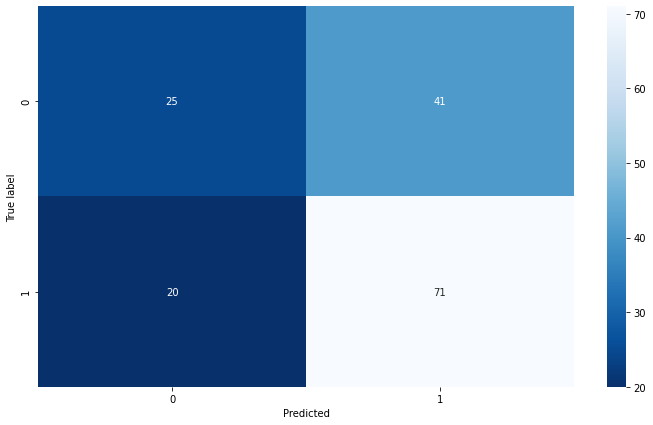

In [99]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')

**Анализ модели:**

_Для заказчика основным показателем этой модели является вкус молока. Следовательно, если модель предскажет, что молоко окажется не вкусным, а на самом деле оно будет вкусным(ошибка 2го рода), то это не критичный случай. Значит, для этой модели критичной является тот факт, если модель предсказала, что молоко будет вкусным, а оно оказалось не вкусным(ошибка 1-го рода)._

_Метрика precision имеет показатель 0.634, что является не подходящим для нашей задачи. Показатель этой метрики чем выше, тем меньше модель ошибается и чаще предсказывает, что молоко вкусное._

**Изменим порог классификации так, чтобы уменьшить ошибку precision:**

In [100]:
def choose_threshold(start_threshold):
    thresholds = [round(i,2) for i in np.linspace(start_threshold,1,num = 12,endpoint=False)]
    y_proba = clf.predict_proba(X_test_ready)[:,1]

    data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)
    for i in thresholds:
        data['y_pred_'+str(i)] = data['y_proba'].apply(lambda y_proba: 1 if y_proba > i else 0)
    
    return data

In [101]:
for feature_number, feature_name in enumerate(X_train.columns):
    weight = clf.coef_[0, feature_number]
    print(f"{feature_name:<20}: {weight:+.6f}") 

crude_protein       : +0.221943
eke_sqrt            : +0.417908
breed               : -0.045979
type_pasture        : +0.663742
age                 : -0.062257
spo_cat             : -0.297900


In [102]:
data_1 = choose_threshold(0.1)
data_1.sample(10)

,y_valid,y_proba,y_pred_0.1,y_pred_0.18,y_pred_0.25,y_pred_0.32,y_pred_0.4,y_pred_0.48,y_pred_0.55,y_pred_0.62,y_pred_0.7,y_pred_0.77,y_pred_0.85,y_pred_0.92
39,1,0.634331,1,1,1,1,1,1,1,1,0,0,0,0
31,1,0.585019,1,1,1,1,1,1,1,0,0,0,0,0
8,1,0.593039,1,1,1,1,1,1,1,0,0,0,0,0
19,0,0.769260,1,1,1,1,1,1,1,1,1,0,0,0
101,1,0.602065,1,1,1,1,1,1,1,0,0,0,0,0
40,1,0.514876,1,1,1,1,1,1,0,0,0,0,0,0
115,0,0.514432,1,1,1,1,1,1,0,0,0,0,0,0
147,0,0.291051,1,1,1,0,0,0,0,0,0,0,0,0
123,1,0.731555,1,1,1,1,1,1,1,1,1,0,0,0
72,0,0.656804,1,1,1,1,1,1,1,1,0,0,0,0


In [103]:
data_2 = choose_threshold(0.5)
data_2.sample(10)

,y_valid,y_proba,y_pred_0.5,y_pred_0.54,y_pred_0.58,y_pred_0.62,y_pred_0.67,y_pred_0.71,y_pred_0.75,y_pred_0.79,y_pred_0.83,y_pred_0.88,y_pred_0.92,y_pred_0.96
68,1,0.348715,0,0,0,0,0,0,0,0,0,0,0,0
73,1,0.675027,1,1,1,1,1,0,0,0,0,0,0,0
147,0,0.291051,0,0,0,0,0,0,0,0,0,0,0,0
55,1,0.840285,1,1,1,1,1,1,1,1,1,0,0,0
51,0,0.462667,0,0,0,0,0,0,0,0,0,0,0,0
70,1,0.716011,1,1,1,1,1,1,0,0,0,0,0,0
66,1,0.838630,1,1,1,1,1,1,1,1,1,0,0,0
142,1,0.747490,1,1,1,1,1,1,0,0,0,0,0,0
89,1,0.796317,1,1,1,1,1,1,1,1,0,0,0,0
61,0,0.593791,1,1,1,0,0,0,0,0,0,0,0,0


In [104]:
precision_score(data_1['y_valid'], data_1['y_pred_0.7'])

0.7894736842105263

In [105]:
precision_score(data_2['y_valid'], data_2['y_pred_0.75'])

0.76

In [106]:
precision_score(data_1['y_valid'], data_1['y_pred_0.85'])

1.0

In [107]:
precision_score(data_2['y_valid'], data_2['y_pred_0.83'])

1.0

In [108]:
precision_score(data_2['y_valid'], data_2['y_pred_0.79'])

0.7777777777777778

In [109]:
data_3 = choose_threshold(0.8)
data_3.sample(10)

,y_valid,y_proba,y_pred_0.8,y_pred_0.82,y_pred_0.83,y_pred_0.85,y_pred_0.87,y_pred_0.88,y_pred_0.9,y_pred_0.92,y_pred_0.93,y_pred_0.95,y_pred_0.97,y_pred_0.98
53,0,0.785419,0,0,0,0,0,0,0,0,0,0,0,0
24,1,0.451179,0,0,0,0,0,0,0,0,0,0,0,0
143,1,0.604270,0,0,0,0,0,0,0,0,0,0,0,0
108,1,0.695104,0,0,0,0,0,0,0,0,0,0,0,0
65,0,0.437603,0,0,0,0,0,0,0,0,0,0,0,0
102,0,0.589380,0,0,0,0,0,0,0,0,0,0,0,0
125,0,0.491056,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0.478706,0,0,0,0,0,0,0,0,0,0,0,0
52,0,0.394259,0,0,0,0,0,0,0,0,0,0,0,0
107,1,0.510563,0,0,0,0,0,0,0,0,0,0,0,0


In [110]:
precision_score(data_3['y_valid'], data_3['y_pred_0.8'])

0.7142857142857143

In [111]:
data_4 = choose_threshold(0.81)
data_4.sample(10)

,y_valid,y_proba,y_pred_0.81,y_pred_0.83,y_pred_0.84,y_pred_0.86,y_pred_0.87,y_pred_0.89,y_pred_0.9,y_pred_0.92,y_pred_0.94,y_pred_0.95,y_pred_0.97,y_pred_0.98
100,1,0.695614,0,0,0,0,0,0,0,0,0,0,0,0
58,0,0.357018,0,0,0,0,0,0,0,0,0,0,0,0
33,0,0.557891,0,0,0,0,0,0,0,0,0,0,0,0
40,1,0.514876,0,0,0,0,0,0,0,0,0,0,0,0
84,0,0.572965,0,0,0,0,0,0,0,0,0,0,0,0
106,0,0.368066,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0.383723,0,0,0,0,0,0,0,0,0,0,0,0
132,1,0.754638,0,0,0,0,0,0,0,0,0,0,0,0
111,1,0.669692,0,0,0,0,0,0,0,0,0,0,0,0
45,1,0.798711,0,0,0,0,0,0,0,0,0,0,0,0


In [112]:
precision_score(data_4['y_valid'], data_4['y_pred_0.81'])

1.0

In [113]:
data_5 = choose_threshold(0.75)
data_5.sample(10)

,y_valid,y_proba,y_pred_0.75,y_pred_0.77,y_pred_0.79,y_pred_0.81,y_pred_0.83,y_pred_0.85,y_pred_0.88,y_pred_0.9,y_pred_0.92,y_pred_0.94,y_pred_0.96,y_pred_0.98
149,0,0.462164,0,0,0,0,0,0,0,0,0,0,0,0
79,0,0.617743,0,0,0,0,0,0,0,0,0,0,0,0
78,0,0.805924,1,1,1,0,0,0,0,0,0,0,0,0
38,1,0.401351,0,0,0,0,0,0,0,0,0,0,0,0
31,1,0.585019,0,0,0,0,0,0,0,0,0,0,0,0
132,1,0.754638,1,0,0,0,0,0,0,0,0,0,0,0
144,1,0.489456,0,0,0,0,0,0,0,0,0,0,0,0
66,1,0.838630,1,1,1,1,1,0,0,0,0,0,0,0
77,1,0.494076,0,0,0,0,0,0,0,0,0,0,0,0
62,0,0.297841,0,0,0,0,0,0,0,0,0,0,0,0


In [114]:
precision_score(data_4['y_valid'], data_5['y_pred_0.77'])

0.7333333333333333

Text(0.5, 42.0, 'Predicted')

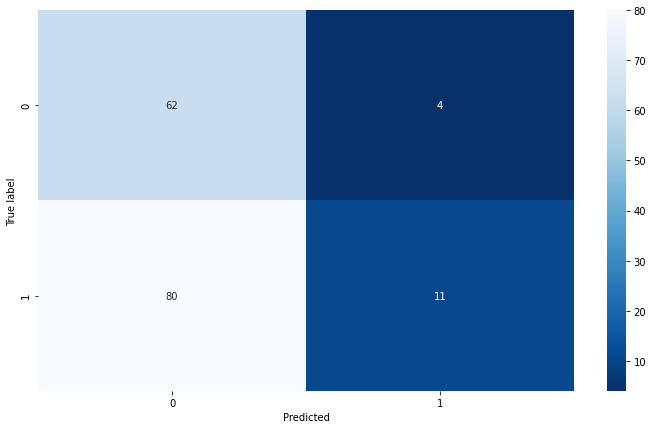

In [115]:
cm = confusion_matrix(y_test, data_5['y_pred_0.77'])

plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')

    - Было определено, что для текущей задачи имеет место минимизировать ошибку первого рода. Следовательно, выбрана метрика precision для решения этой задачи.
    - Исходя из значения метрики precision для различных порогов, был выбран порог 0.77 как наилучший, при которой precision = 0.73(3) с приемлемым отклонением от 1 и без потери адекватности модели.
    - На матрице ошибок видно, что ошибка первого рода была минимизирована.
    - Дальше можно попробовать добавить дополнительные входные признаки в модель, чтобы улучшить прогноз. При текущем подходе нужно большое количество коров, чтобы точно получить корову, которая дает вкусное молоко.

In [116]:
cow_buy_scaled = scaler.transform(cow_buy[['crude_protein', 'eke_sqrt']])
cow_buy_encoded = encoder.transform(cow_buy[['breed', 'type_pasture', 'age', 'spo_cat']])
cow_buy_data_class = np.concatenate((cow_boy_scaled, cow_buy_encoded), axis=1)

In [117]:
dfc = pd.DataFrame(clf.predict_proba(cow_buy_data_class)[:,1] >= 0.77)
dfc.columns = ['taste']

In [118]:
cow_buy_taste = pd.concat([dfc, cow_buy], axis=1)
cow_buy_taste

,taste,breed,type_pasture,breed_dad,dad_name,current_fat_content,current_protein,age,eke,crude_protein,spo,eke_sqrt,spo_cat
0,False,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
1,False,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1
2,False,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
3,False,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
4,False,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
5,False,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1
6,False,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
7,False,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
8,False,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
9,False,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1


**Вывод:**

    - Было определено, что для текущей задачи имеет место минимизировать ошибку первого рода. Следовательно, выбрана метрика precision для решения этой задачи.
    - Исходя из значения метрики precision для различных порогов, был выбран порог 0.77 как наилучший, при которой precision = 0.73(3) с приемлемым отклонением от 1 и без потери адекватности модели.
    - На матрице ошибок видно, что ошибка первого рода была минимизирована.
    - Дальше можно попробовать добавить дополнительные входные признаки в модель, чтобы улучшить прогноз. При текущем подходе нужно большое количество коров, чтобы точно получить корову, которая дает вкусное молоко.
    - Также получили прогноз по вкусу молока из таблицы cow_buy и в результате прогноза - молоко будет не вкусное у всех коров.

## Итоговые выводы

**Загрузка данных:**
    
    - Были выгружены данные из трех разных файлов в три переменные.
    - В таблице ferma_main 634 записи с колонками Идентификатора коровы, Удой(целевая), ЭКЕ (Энергетическая кормовая единица), Сырой протеин, СПО (Сахаро-протеиновое соотношение), Порода, Тип пастбища', порода папы_быка, Жирность, Белок, Вкус молока, Возраст.
    - В таблице ferma_dad 629 записи с колонками идентификатора коровы, имя папы.
    - В таблице cow_buy 20 записей с колонками Порода, Тип пастбища, порода папы_быка, Имя_папы, Текущая_жирность, Текущий_уровень_белок, Возраст.

**Предобратока данных:**

    - Поля были переименованы и нормализованы к snake case.
    - Был приведен тип float, в полях, где он был строкой.
    - Дубликаты были устранены, как явные, так и неявные в таблицах ferma_main и cow_buy(в таблице ferma_dad дубликатов не найдено).
    - Пропущенных значений найдено не было.

**Исследовательский анализ:**

    - Коровы с возрастом более 2 лет составляют большую долю от всех коров фермы
    - Видим, что количество породы Вис Бик Айдиал слегка преобладает(почти на 10 процентов)
    - Имена Барин и Буйный преобладают. Имена важны как социально-культурный фактор для удоя молока. Например, исследования показывают, что коровы с именами дают больше молока
    - Удой относительно ЭКЕ не выявил каких либо выбросов. Тем не менее распределение удоя относительно количество коров выявило выброс на значении 45616 и был устранен. Оба признака не соответствуют нормальному распределению.
    - Из данных по отношению пищи и молока к Удою видно, что Белок молока имеет нормальное распределение, в отличие от остальных показателей. Жирность молока в районе 3.73 показало наиболее благоприятные статистические показатели для Удоя. А также СПО в районе 0.93-0.94 хорошо сказывается на удое. Сырой протеин в районе 1700-1850 г давали наибольшему числу коров.
    - Доля вкусного молока составляет 59% от всего.
    - Соотношение породы к вкусу молока показывает, что порода не повлияла на вкус молока в текущей выборке. Так как имеем процент породы вкусного и не вкусного молока равным к общему соотношению пород.
    - Показатели по пище говорят о том, что жирность пищи примерно одинакова до показателя от 3.71 до 3.73 - в этом показателе количество вкусного молока больше всего. Белок практически не влияетна не вкусное молоко, тем не менее больше всего вкусного на показателе 3.076. СПО указывает на равные показатели на 0.93, тем не менее при показателе 0.9 появляется только для не вкусного молока, хоть и незначительна, но ее проще избежать. Так же сравнивая 0.89 и 0.95 мы имеем большую долю вкусного молока, чем не вкусного.

**Корреляционный анализ:**

    - Был обнаружен риск мультиколлинеарности - dad_name и breed_dad имели коэффициент корреляциии больше 0.9. Путем удаления поля dad_name был устранен весьма высокий показатель корреляции.
    - Можем наблюдать, что признак spo(СПО) и fat_content(Жирность) и eke(ЭКЕ) коррелируют между собой.
    - Наблюдается высокая корреляция у признаков СПО, Жирность и Белок.
    - Низкая корреляция у показателей Эке и Сырой протеин.
    - Нелинейная связь у Сырым протеином, ЭКЕ и удоем(сильная корреляция), жирность
    - Линейная связь у сырого протеина с удоем.
    - Чтобы убрать нелинейность - следует, масштабировать признаки. Новые признаки вводить не придется.

**Обучение модели линейной регрессии:**
    
    - Сравнивая все три модели можно сказать, что последняя наиболее приемлема для работы по всем показателям. Первая модель, хоть и имеет метрику R2 лучше, чем вторая, тем не менее из-за графика смещенного влево она будет плохо предсказывать малый удой. Вторая модель лучше первой по всем метрикам, кроме R2(в тысячных) и больше пригодна для предсказаний чем первая. Третья модель имеет наибольшую метрику R2 и это закреплено анализом дисперсии, график так же имеет хорошее распределение, лучшее из всех трех вариантов.
    - Самая лучшая модель - 3, покрытие доверительного интервала составляет 94.90%
    - Так же был выполнен прогноз для таблицы cow_buy и получено, что в среднем молока можно получить 6384кг с коровы.

**Обучение модели логистической регрессии:**

    - Было определено, что для текущей задачи имеет место минимизировать ошибку первого рода. Следовательно, выбрана метрика precision для решения этой задачи.
    - Исходя из значения метрики precision для различных порогов, был выбран порог 0.77 как наилучший, при которой precision = 0.73(3) с приемлемым отклонением от 1 и без потери адекватности модели.
    - На матрице ошибок видно, что ошибка первого рода была минимизирована.
    - Дальше можно попробовать добавить дополнительные входные признаки в модель, чтобы улучшить прогноз. При текущем подходе нужно большое количество коров, чтобы точно получить корову, которая дает вкусное молоко.
    - Также получили прогноз по вкусу молока из таблицы cow_buy и в результате прогноза - молоко будет не вкусное у всех коров.

**Результаты работы моделей:**

In [119]:
cow_buy_predicts = pd.concat([dfc, cow_buy_yield], axis=1)

In [120]:
cow_buy_predicts

,taste,"Удой, кг",breed,type_pasture,breed_dad,dad_name,current_fat_content,current_protein,age,eke,crude_protein,spo,eke_sqrt,spo_cat
0,False,6544.794502,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
1,False,6222.316191,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1
2,False,6229.489980,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
3,False,6583.599683,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
4,False,6514.110616,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
5,False,6226.737169,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1
6,False,6544.794502,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
7,False,6492.497537,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
8,False,6229.489980,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
9,False,6313.418337,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1


In [121]:
cow_buy_predicts.loc[(cow_buy_predicts['Удой, кг'] > 6000) & (cow_buy_predicts['taste'])]

,taste,"Удой, кг",breed,type_pasture,breed_dad,dad_name,current_fat_content,current_protein,age,eke,crude_protein,spo,eke_sqrt,spo_cat


_Фермеру, согласно прогнозам моделей, не следует покупать коров у этой фирмы. Так как, хоть и удой будет удовлетворительный по количеству, тем не менее вкусного молока среди всех коров, не ожидается._

_Вероятно, следует запросить больше данных или обратить внимание на коров с другим питанием(если таковые имеются у фирмы поставщика)._

_Так же можно провести опрос и последующий анализ у потребителей, с целью последующей возможности понижения качества молока. В случае, если анализ покажет положительный результат в этом направлении._

_Наконец, возможно стоит рассмотреть ряд других фирм поставщиков, в случае, если модели в точности предскажут вкус и количество молока на проде._

**Выводы о моделях линейной регрессии и логистической регрессии:**

_В задаче использовались методы улучшения качества моделей:_

    - Введены дополнительные входные признаки(ЕКЭ в квадрате, категоризировали СПО признак).
    - Для логистической регрессии был выбран порог классификации в 0.82.
    - Был проведен анализ остатков для оценки качества линейной модели.
    - Был проанализирован и минимизирован показатель precision(ошибка первого рода) для логистической модели.

_Улучшить результаты регрессионных моделей возможно введением дополнительных входных признаков. Например, параметры корма или дополнительные, специфические услвоия содержания коров._

_При анализе рисков важно обращать внимание на метрики ошибок R², MAE, RMSE, MSE для логической регрессии и метрики accuracy, precision, recall для логистической. Так же при работе с логистической моделью стоит обратить внимание на матрицу ошибок, чтобы наглядно определить какой род ошибки доминирует. Так же важно анализировать остатки, в случае линейной регрессии._